In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

/Users/achille/opt/miniconda3/envs/cdae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


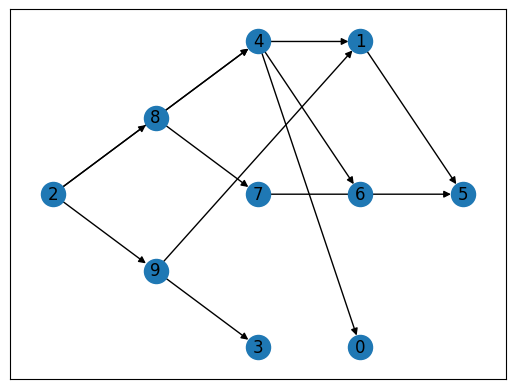

In [2]:
import networkx as nx

from causal_model import CausalModel, scale_mechanism
from simulated_data import random_dag, generate_gaussian_mlp_fixed_scale_mechanisms, draw_dag_topological_sort


import matplotlib.pyplot as plt
import seaborn as sns

from utils import set_random_seed_all
set_random_seed_all(0)

dag = random_dag(10, 12)

draw_dag_topological_sort(dag)

In [3]:
causal_model = CausalModel(dag)
observational_mechanisms = generate_gaussian_mlp_fixed_scale_mechanisms(causal_model, [], scale=lambda x: 1-x/10)
causal_model.set_causal_mechanisms(observational_mechanisms)

n_interventions = 10
tau = 0
# let's only intervene on one node at a time, by knocking down their mechanisms by tau
for i in range(n_interventions):
    nodes = [str(i)]
    new_intervened_mechanisms = {
        n: scale_mechanism(observational_mechanisms[n], tau) for n in nodes
    }
    causal_model.set_intervention(str(i), new_intervened_mechanisms)

In [4]:
causal_model.causal_mechanisms["2"].conditional_parameters_func.extra_outputs

{'scale': 1.0}

In [5]:
causal_model.causal_mechanisms["8"].conditional_parameters_func.extra_outputs

{'scale': 0.9}

<Axes: xlabel='2', ylabel='8'>

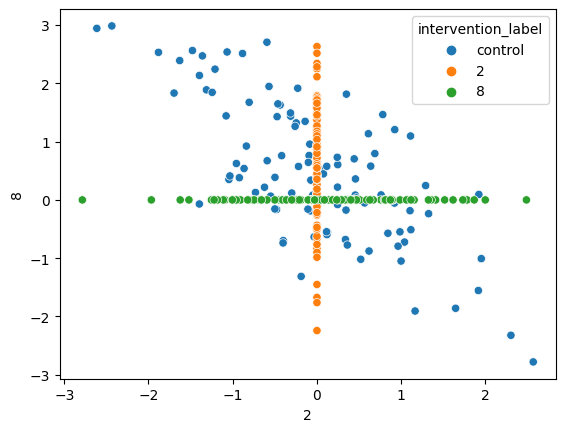

In [6]:
data = causal_model.generate_dataframe_from_all_distributions(100, 100, ["2", "8"])

sns.scatterplot(data=data, x="2", y="8", hue="intervention_label", hue_order=["control", "2", "8"])

<Axes: xlabel='1', ylabel='5'>

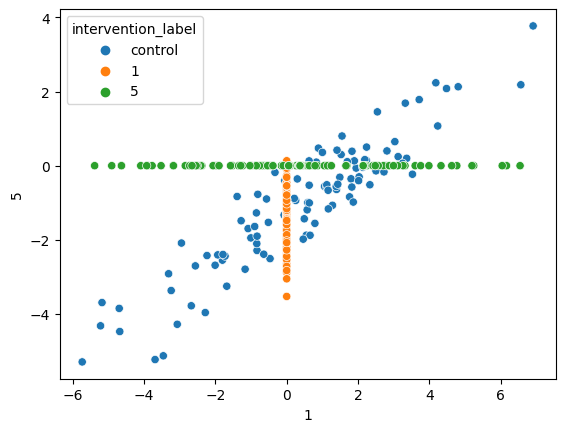

In [7]:
data = causal_model.generate_dataframe_from_all_distributions(100, 100, ["1", "5"])

sns.scatterplot(data=data, x="1", y="5", hue="intervention_label", hue_order=["control", "1", "5"])